In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

In [4]:
df = pd.read_csv("Student_Performance.csv") #Зчитування датасету

#Розвідковий аналіз (EDA)
df.info()
print("\n")
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB




,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [5]:
#Чи є null-значення в кожній з колонок
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

<Axes: >

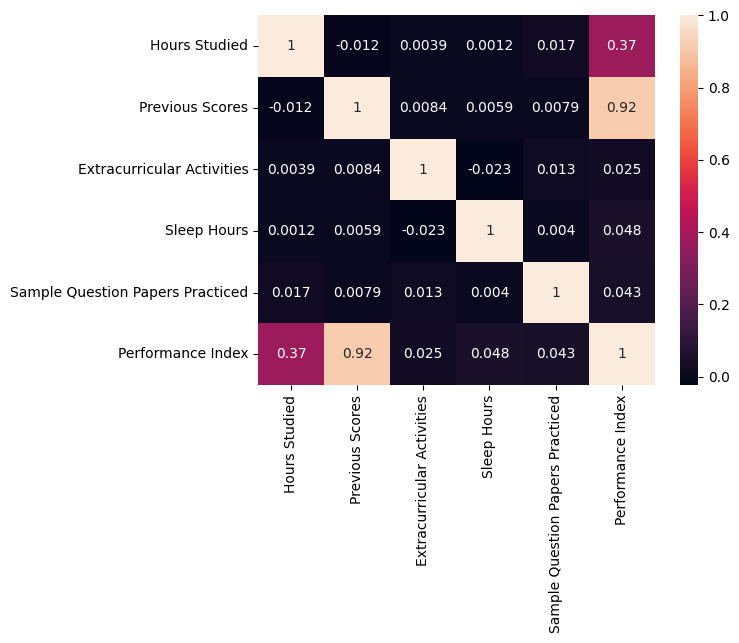

In [6]:
#Обробка категоріальної змінної "Extracurricular Activities"
df["Extracurricular Activities"] = df["Extracurricular Activities"].map({"No": 0, "Yes": 1})

#Хіт-мапа кореляцій
sns.heatmap(df.corr(), annot=True)

In [7]:
#Вибір ознак та цільової змінної, розбиття даних на тренувальні та тестові 
y = df["Performance Index"]
X = df.drop(columns=["Performance Index"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#Нормалізація/Стандартизація
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Додаємо стовпчик одиниць для intercept
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

In [10]:
#Реалізація методу градієнтного спуску
b = np.zeros(X_train_final.shape[1]) #Вектор ваг beta

epochs=1000 #К-сть ітерацій
learning_rate=0.01 #Швидкість навчання

In [11]:
#Функція для обчислення функції втрат (MSE)
def compute_cost(X, y, b):
    predictions = X.dot(b)
    errors = predictions - y
    mse = (1 / len(y)) * np.sum(errors ** 2)
    return mse

#Функція градієнтного спуску
def gradient_descent(X, y, b, learning_rate, epochs):
    cost_history = [] # Для відстеження змін MSE
    m = len(y)
    
    for _ in range(epochs):
        # Обчислення передбачень
        y_pred = np.dot(X, b)
    
        # Обчислення помилки
        error = y_pred - y
    
        # Обчислення градієнта (похідна MSE за b)
        gradient = (1/m) * np.dot(X.T, error)
    
        # Оновлення ваг
        b = b - learning_rate * gradient
    
        # Збереження поточного MSE для історії
        mse = (1/m) * np.sum(error ** 2)
        cost_history.append(mse)
    
    return b, cost_history

Коефіцієнти b_final: 
[55.30911213  7.40093109 17.63646538  0.30430629  0.81002051  0.54895455]


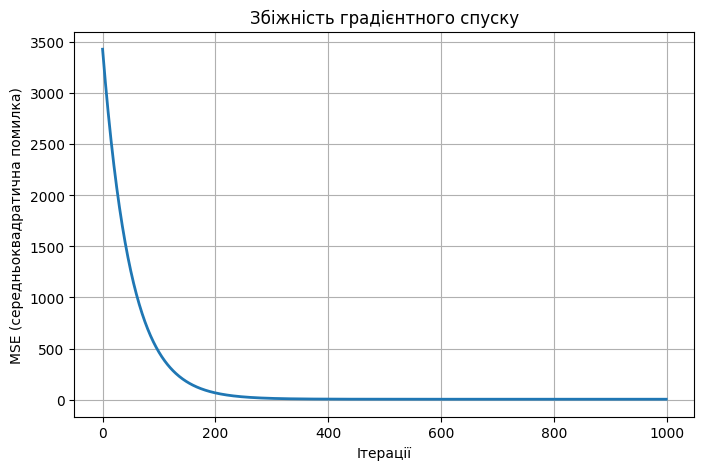

In [12]:
#Градієнтний спуск на тренувальних даних
b_final, cost_history = gradient_descent(X_train_final, y_train, b, learning_rate, epochs) 
print("Коефіцієнти b_final: ")
print(b_final)

#Візуалізація навчання
plt.figure(figsize=(8,5))
plt.plot(range(len(cost_history)), cost_history, marker='', linewidth=2)
plt.xlabel("Ітерації")
plt.ylabel("MSE (середньоквадратична помилка)")
plt.title("Збіжність градієнтного спуску")
plt.grid(True)
plt.show()

In [ ]:
#Функція втрат зменшується зі збільшенням к-сті ітерації, все добре

In [13]:
#Прогнозування
y_pred = X_test_final.dot(b_final)

#Розрахунок метрик
mse_test = np.mean((y_test - y_pred) ** 2)
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

#baseline
y_baseline = np.full_like(y_test, np.mean(y_train))
mse_baseline = np.mean((y_test - y_baseline) ** 2)
r2_baseline = 1 - (np.sum((y_test - y_baseline) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

#Порівняння з baseline
print("Оцінка моделі:")
print(f"MSE (тест): {mse_test:.4f}")
print(f"R² (тест): {r2:.4f}")

print("\nБейзлайн (середнє y_train):")
print(f"MSE (baseline): {mse_baseline:.4f}")
print(f"R² (baseline): {r2_baseline:.4f}")

Оцінка моделі:
MSE (тест): 4.0825
R² (тест): 0.9890

Бейзлайн (середнє y_train):
MSE (baseline): 370.7730
R² (baseline): -0.0005


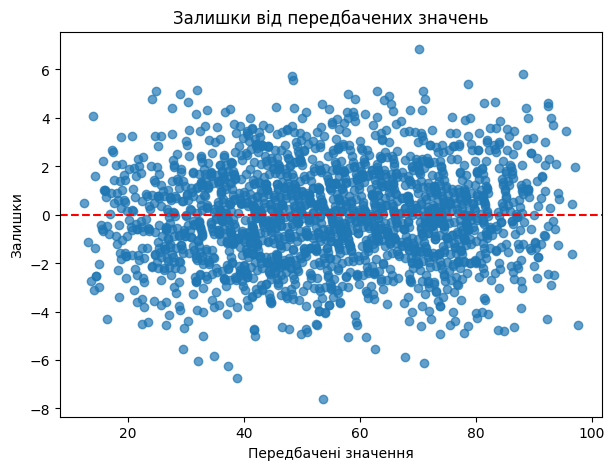

In [13]:
#Лінійність та гомоскедастичність
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Передбачені значення")
plt.ylabel("Залишки")
plt.title("Залишки від передбачених значень")
plt.show()

In [14]:
#Залишки випадково розкинулися навколо нуля, що й було очікувано для лінійності зв’язку
#та "хмара" точок має приблизно однакову ширину по всій довжині, що доводить гомоскедастичність

In [23]:
#Відсутність мультиколінеарності (VIF)
X_with_const = sm.add_constant(X_train)  #додаємо константу

vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                   for i in range(X_with_const.shape[1])]

print("\nVIF для кожної ознаки:\n", vif_data)


VIF для кожної ознаки:
                             feature        VIF
0                             const  39.149899
1                     Hours Studied   1.000387
2                   Previous Scores   1.000243
3        Extracurricular Activities   1.000428
4                       Sleep Hours   1.000461
5  Sample Question Papers Practiced   1.000320


In [18]:
#Всі, окрім const, є менше 5, що вказують на відсутність серйозної мультиколінеарності

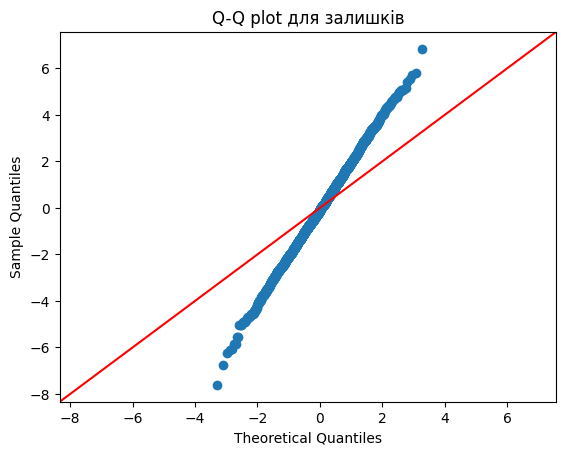


Shapiro-Wilk Test: W=0.9996, p=0.9750


In [17]:
#Нормальність залишків
#Q-Q plot
sm.qqplot(residuals, line='45')
plt.title("Q-Q plot для залишків")
plt.show()

#Тест Шапіро-Уїлка
shapiro_test = stats.shapiro(residuals)
print("\nShapiro-Wilk Test: W=%.4f, p=%.4f" % (shapiro_test[0], shapiro_test[1]))

In [16]:
#Точки на плоті лежать приблизно на прямій лінії та результат тесту є більше за 0.05, 
#що вказує на нормальність залишків

In [18]:
#Автокореляція залишків (Durbin-Watson)
dw_stat = durbin_watson(residuals)
print("\nDurbin-Watson statistic:", dw_stat)


Durbin-Watson statistic: 2.0473842142537704


In [17]:
#Результат приблизно дорівнює 2, що означає відсутність автокореляції

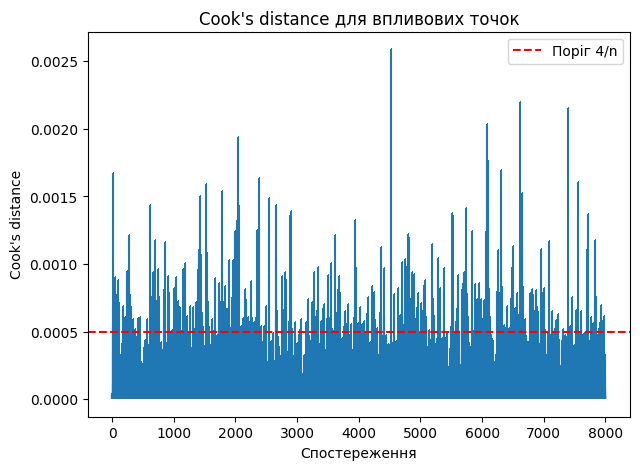

In [19]:
#Викиди та впливові спостереження (Cook's Distance)
model_sm = sm.OLS(y_train, X_train_final).fit()
influence = model_sm.get_influence()
cooks_d = influence.cooks_distance[0]

#Поріг для Cook's D
n = len(y_train)
threshold = 4 / n

plt.figure(figsize=(7,5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.axhline(threshold, color="red", linestyle="--", label="Поріг 4/n")
plt.xlabel("Спостереження")
plt.ylabel("Cook's distance")
plt.title("Cook's distance для впливових точок")
plt.legend()
plt.show()

In [19]:
#Є незначна кількість викидів, що може змістити оцінки параметрів, 
#спотворити прогноз, в наслідок чого можна зробити хибні висновки про успішність студентів

#Висновок: реалізовано алгоритм множинної лінійної регресії з нуля за допомогою методу градієнтного спуску. 
#Проведено повний аналіз якості моделі, включаючи перевірку всіх шести класичних припущень МНК, 5 з яких успішно виконуються. 
#Модель придатна, але варто переглянути впливові спостереження, можна проаналізувати модель з і без цих точок.